In [17]:
### 4. 평가 (Evaluation) ###

# 머신러닝의 과정

![Alt text](image.png)

In [18]:
# 회귀의 성능 평가
# - 오차 평균 기반

# 분류의 성능 평가
# - 정확도 (Accuracy)
# - 오차 행렬 (Confusion Matrix)
# - 정밀도 (Precision)
# - 재현율 (Recall)
# - F1 스코어
# - ROC AUC

In [19]:
# 정확도 (Accuracy)

# 실제 데이터에서 예측 데이터가 얼마나 같은지 판단하는 지표
# 이진 분류의 경우 데이터 구성에 따라 머신 러닝 모델의 성능을 왜곡할 수 있음

![Alt text](image-1.png)

In [20]:
# 왜곡의 예

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator

def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace = True)
    df['Cabin'].fillna('N', inplace = True)
    df['Embarked'].fillna('N', inplace = True)
    df['Fare'].fillna(0, inplace = True)
    return df

def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis = 1, inplace = True)
    return df
    
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df
    
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

class MyDummyClassifier(BaseEstimator):
    def fit(self, x, y = None):
        pass
    
    def predict(self, x):
        pred = np.zeros((x.shape[0], 1))
        for i in range(x.shape[0]):
            if x['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
        return pred
    
titanic_df = pd.read_csv('C:/woogi/KWU/3-2/Machine_Learning/titanic.csv')
y_titanic_df = titanic_df['Survived']
x_titanic_df = titanic_df.drop('Survived', axis = 1)
x_titanic_df = transform_features(x_titanic_df)
x_train, x_test, y_train, y_test = train_test_split(x_titanic_df, y_titanic_df, test_size = 0.2)

myclf = MyDummyClassifier()
myclf.fit(x_train, y_train)

mypredictions = myclf.predict(x_test)
print(accuracy_score(y_test, mypredictions))

0.7821229050279329


In [21]:
# 앞의 예시에서 단순히 Sex 가 1이면 죽음 (0), 아니면 생존 (1)으로 처리하여도
# 정확도가 0.7 ~ 0.8 의 높은 값을 얻음

# 레이블 값 분포가 불균형한 경우 적합한 평가 지표가 아님
# - 100개의 데이터 중 90개는레이블이 0, 10개는 1인 경우
# - 예측 결과를 무조건 0으로 반환해도 정확도가 90%

# 왜곡의 예
# - MNIST 데이터 중 레이블 7만 True, 나머지는 False
#   -> 이진 분류 문제로 변경
#   -> 전체 데이터의 10%는 True, 90%는 False
# - 예측 값을 무조건 0으로 반환해도 정확도가 90%

from sklearn.datasets import load_digits

class MyFakeClassifier(BaseEstimator):
    def fit(self, x, y):
        pass
    
    def predict(self, x):
        return np.zeros((x.shape[0], 1), dtype = int)
    
digits = load_digits()
y = (digits.target == 7).astype(int)

x_train, x_test, y_train, y_test = train_test_split(digits.data, y)
print(y_test.shape)
print(pd.Series(y_test).value_counts())

clf = MyFakeClassifier()
clf.fit(x_train, y_train)

predictions = clf.predict(x_test)
print(accuracy_score(y_test, predictions))

(450,)
0    401
1     49
Name: count, dtype: int64
0.8911111111111111


In [22]:
# 오차 행렬 (Confusion Matrix)

# 예측 오류가 얼마인지와 어떤 유형의 예측 오류가 발생하는 지를 나타냄

# - TN : Negative(0) 으로 예측했는데 그게 맞는 경우
# - FP : Positive(1) 으로 예측했는데 그게 틀린 경우
# - FN : Negative(0) 으로 예측했는데 그게 틀린 경우
# - TP : Positive(1) 으로 예측했는데 그게 맞는 경우

![Alt text](image-2.png)

In [23]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, predictions))

[[401   0]
 [ 49   0]]


![Alt text](image-3.png)

In [24]:
# 정밀도 (Precision)와 재현율 (Recall)

# Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표

![Alt text](image-4.png)

In [25]:
# 정밀도 (Precision)
# - Positive 로 예측한 것 중 맞게 예측한 것의 비율
# - 양성 예측도 (Positive 예측 성능을 더운 정밀하게 측정)라고도 함
# - 실제로는 negative 인데 Positive 로 잘못 판단하면 큰 일 나는 경우에 적용
# - (예) 스팸 메일 판단 모델
#        Positive 를 Negative 로 판단하면 불편함 정도
#        Negative 를 Positive 로 판단하면 업무 차질

In [26]:
# 재현율 (Recall)
# - 정답이 Positive 인 것 중 맞게 예측한 것의 비율
# - 민감도 (Sensitivity), TPR (True Positive Rate) 라고도 함
# - 실제로는 Positive 인데 Negative 로 잘못 판단하면 큰 일 나는 경우에 적용
# - (예) 암 판단 모델:
#        Positive 를 Negative 로 판단하면 생명에 큰 일
#        Negative 를 Positive 로 판단하면 재검사 정도
# - (예) 금융 사기 적발 모뎅:
#        Positive 를 Negative 로 판단하면 회사에 큰 손해
#        Negative 를 Positive 로 판단하면 재확인 정도

In [27]:
# 정밀도 vs 재현뮬
# - 분자는 같음
# - 정밀도는 FP 를 낮추는 데 초점
# - 재현율은 FN 을 낮추는 데 초점
# - 정밀도와 재현율 모두 높은 것이 좋음
# - 둘 중 하나만 높고 하나만 낮으면 안 좋음

![Alt text](image-5.png)

In [28]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

df = pd.read_csv('C:/woogi/KWU/3-2/Machine_Learning/titanic.csv')

df.drop(['PassengerId', 'Name', 'Ticket'], axis = 1, inplace = True)

df['Age'].fillna(df['Age'].mean(), inplace = True)
df['Cabin'].fillna('N', inplace = True)
df['Embarked'].fillna('N', inplace = True)
df['Cabin'] = df['Cabin'].str[:1]

encoder = LabelEncoder()
df['Cabin'] = encoder.fit_transform(df['Cabin'])
df['Sex'] = encoder.fit_transform(df['Sex'])
df['Embarked'] = encoder.fit_transform(df['Embarked'])

y = df['Survived']
x = df.drop('Survived', axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver = 'liblinear')
lr.fit(x_train, y_train)
y_hat = lr.predict(x_test)

print(confusion_matrix(y_test, y_hat))
print(accuracy_score(y_test, y_hat))
print(precision_score(y_test, y_hat))
print(recall_score(y_test, y_hat))


[[92 21]
 [22 44]]
0.7597765363128491
0.676923076923077
0.6666666666666666


In [29]:
# 트레이드오프 (Trade - Off)
# - 정밀도 / 재현율이 강조되어야 하는 경우
#   -> 분류의 임곗값을 조정하면 바뀔 수 있음
# - 한 쪽을 높이면 다른 쪽이 떨어질 수 있음
# - predict_proba() : 테스트 데이터에 대해 예측 확률 반반

proba = lr.predict_proba(x_test)
result = np.concatenate([proba, y_hat.reshape(-1, 1)], axis = 1)
print(result)

[[0.90511278 0.09488722 0.        ]
 [0.75260822 0.24739178 0.        ]
 [0.09603074 0.90396926 1.        ]
 [0.76005289 0.23994711 0.        ]
 [0.54421808 0.45578192 0.        ]
 [0.91165773 0.08834227 0.        ]
 [0.59250586 0.40749414 0.        ]
 [0.86382347 0.13617653 0.        ]
 [0.69149042 0.30850958 0.        ]
 [0.24363097 0.75636903 1.        ]
 [0.07846903 0.92153097 1.        ]
 [0.89601741 0.10398259 0.        ]
 [0.71540354 0.28459646 0.        ]
 [0.60800313 0.39199687 0.        ]
 [0.84894629 0.15105371 0.        ]
 [0.07548864 0.92451136 1.        ]
 [0.84722639 0.15277361 0.        ]
 [0.86671965 0.13328035 0.        ]
 [0.15080791 0.84919209 1.        ]
 [0.67279512 0.32720488 0.        ]
 [0.7472538  0.2527462  0.        ]
 [0.35761882 0.64238118 1.        ]
 [0.78874731 0.21125269 0.        ]
 [0.78890949 0.21109051 0.        ]
 [0.71540354 0.28459646 0.        ]
 [0.66078419 0.33921581 0.        ]
 [0.77802632 0.22197368 0.        ]
 [0.66336866 0.33663134 0.  

In [30]:
# Binarizer 클래스
# - fit_transform() : 지정된 문턱 값보다 크면 1, 아니면 0 으로 반환

from sklearn.preprocessing import Binarizer

tmp = [[1, -1, 2],
       [2, 0, 0],
       [0, 1.1, 1.2]]
binarizer = Binarizer(threshold = 1.1)
print(binarizer.fit_transform(tmp))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [31]:
pr = proba[:, 1].reshape(-1, 1)

y_hat = Binarizer(threshold = 0.5).fit_transform(pr)
print(confusion_matrix(y_test, y_hat))
print(accuracy_score(y_test, y_hat))
print(precision_score(y_test, y_hat))
print(recall_score(y_test, y_hat))

[[92 21]
 [22 44]]
0.7597765363128491
0.676923076923077
0.6666666666666666


In [32]:
for th in [0.4, 0.45, 0.5, 0.55, 0.6]:
    y_hat = Binarizer(threshold = th).fit_transform(pr)
    print(confusion_matrix(y_test, y_hat))
    print(accuracy_score(y_test, y_hat))
    print(precision_score(y_test, y_hat))
    print(recall_score(y_test, y_hat))

[[84 29]
 [21 45]]
0.7206703910614525
0.6081081081081081
0.6818181818181818
[[88 25]
 [22 44]]
0.7374301675977654
0.6376811594202898
0.6666666666666666
[[92 21]
 [22 44]]
0.7597765363128491
0.676923076923077
0.6666666666666666
[[95 18]
 [22 44]]
0.776536312849162
0.7096774193548387
0.6666666666666666
[[96 17]
 [24 42]]
0.770949720670391
0.711864406779661
0.6363636363636364


![Alt text](image-6.png)

In [33]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, ths = precision_recall_curve(y_test, pr)

N = ths.shape[0]
index = np.arange(0, N, 15)
print(index)

print(ths[index])
print(precisions[index])
print(recalls[index])

[  0  15  30  45  60  75  90 105 120 135 150 165]
[0.01569339 0.09384005 0.11628842 0.13906514 0.15934517 0.22197368
 0.31033445 0.45578192 0.63568978 0.69110377 0.81702817 0.92451136]
[0.36871508 0.39634146 0.41891892 0.45038168 0.49137931 0.53
 0.58333333 0.63768116 0.72222222 0.81081081 0.95454545 1.        ]
[1.         0.98484848 0.93939394 0.89393939 0.86363636 0.8030303
 0.74242424 0.66666667 0.59090909 0.45454545 0.31818182 0.10606061]


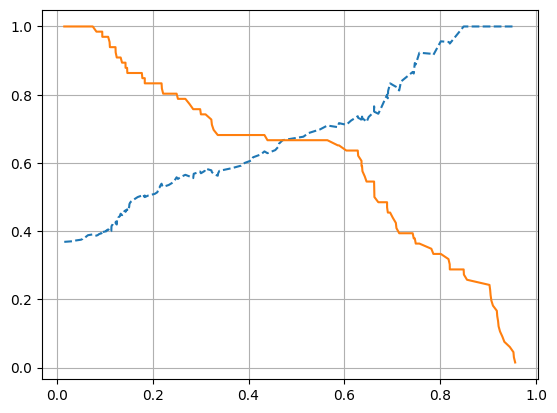

In [34]:
import matplotlib.pyplot as plt

N = ths.shape[0]
plt.plot(ths, precisions[:N], '--')
plt.plot(ths, recalls[:N])
plt.grid()

In [35]:
# 맹점
# - 환자 1000명 중에서 확실한 Positive 징후 환자 1명만 Positive,
#   나머지는 Negative 로 예픅
#   -> TP = 1, FP = 0 -> 정밀도 = 100%
# - 모든 환자를 Positive 로 예측, 실제 양성은 30명
#   -> FN = 0, TP = 30 -> 재현율 = 100%

![Alt text](image-7.png)

In [36]:
# F1 스코어
# - 정밀도와 재현율 결합
# - 정밀도 0.9, 재현율 0.1 -> F1 = 0.18
# - 정밀도 0.5, 재현율 0.5 -> F1 = 0.5

![Alt text](image-8.png)

In [37]:
from sklearn.metrics import f1_score

for th in [0.4, 0.45, 0.5, 0.55, 0.6]:
    y_hat = Binarizer(threshold = th).fit_transform(pr)
    print(confusion_matrix(y_test, y_hat))
    print(accuracy_score(y_test, y_hat))
    print(precision_score(y_test, y_hat))
    print(recall_score(y_test, y_hat))
    print(f1_score(y_test, y_hat))

[[84 29]
 [21 45]]
0.7206703910614525
0.6081081081081081
0.6818181818181818
0.6428571428571428
[[88 25]
 [22 44]]
0.7374301675977654
0.6376811594202898
0.6666666666666666
0.6518518518518518
[[92 21]
 [22 44]]
0.7597765363128491
0.676923076923077
0.6666666666666666
0.6717557251908397
[[95 18]
 [22 44]]
0.776536312849162
0.7096774193548387
0.6666666666666666
0.6875
[[96 17]
 [24 42]]
0.770949720670391
0.711864406779661
0.6363636363636364
0.672


![Alt text](image-9.png)

In [38]:
# ROC 곡선과 AUC

# ROC 곡선 (Receiver Operation Characteristic Curve)
# - FPR (False Positive Rate) 이 변할 때 TPR (True Positive Rate) 이 어떻게 변하는지 나타내는 곡선
# - x축 : FPR, y축 : TPR

![Alt text](image-10.png)

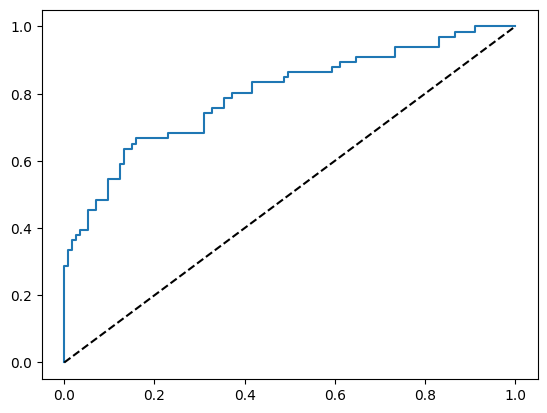

In [39]:
from sklearn.metrics import roc_curve

fprs, tprs, ths = roc_curve(y_test, pr)
plt.plot(fprs, tprs)
plt.plot([0, 1], [0, 1], 'k--')

![Alt text](image-11.png)

In [40]:
# AUC (Area Under Curve)
# - ROC 아래의 면적
# - 1에 가까울수록 좋음

from sklearn.metrics import roc_auc_score

print(confusion_matrix(y_test, y_hat))
print(accuracy_score(y_test, y_hat))
print(precision_score(y_test, y_hat))
print(recall_score(y_test, y_hat))
print(f1_score(y_test, y_hat))
print(roc_auc_score(y_test, pr))

[[96 17]
 [24 42]]
0.770949720670391
0.711864406779661
0.6363636363636364
0.672
0.7969965138106732


In [41]:
# 피마 인디언 당뇨병 분류

# 피처들
# - Pregnancies : 임신 횟수
# - Glucose : 포도당 부하 검사 수치
# - BloodPressure : 혈압
# - SkinThickness : 팔 삼두근 뒤쪽의 피하지방 측정값
# - Insulin : 혈청 인슐린
# - BMI : 체질량지수
# - DiabetesPedigreeFunction : 당뇨 내력 가중치 값
# - Age : 나이
# - Outcome : 클래스 결정 값 (0 또는 1)

diabetes = pd.read_csv('C:/woogi/KWU/3-2/Machine_Learning/archive/diabetes.csv')
print(diabetes['Outcome'].value_counts())

Outcome
0    500
1    268
Name: count, dtype: int64


In [42]:
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [43]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [44]:
x = diabetes.iloc[:, :-1]
y = diabetes.iloc[:, -1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y)

lr = LogisticRegression(solver = 'liblinear')
lr.fit(x_train, y_train)
y_hat = lr.predict(x_test)
y_prob = lr.predict_proba(x_test)[:, 1]

print(confusion_matrix(y_test, y_hat))
print(accuracy_score(y_test, y_hat))
print(precision_score(y_test, y_hat))
print(recall_score(y_test, y_hat))
print(f1_score(y_test, y_hat))
print(roc_auc_score(y_test, y_prob))

[[90 10]
 [22 32]]
0.7922077922077922
0.7619047619047619
0.5925925925925926
0.6666666666666666
0.8518518518518519


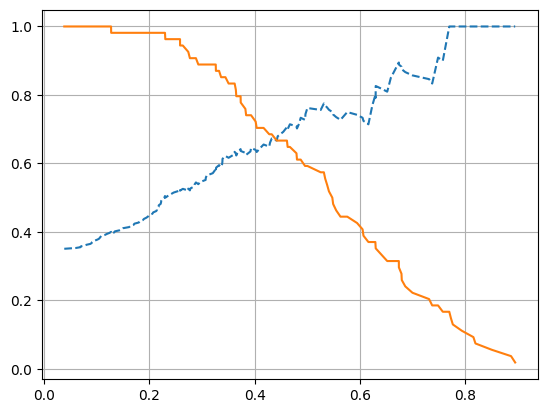

In [45]:
precisions, recalls, ths = precision_recall_curve(y_test, y_prob)
N = ths.shape[0]
plt.plot(ths, precisions[:N], '--')
plt.plot(ths, recalls[:N])
plt.grid()

In [46]:
diabetes.describe()
# min 값이 0인 피처가 많음

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


(array([  5.,   0.,   4.,  32., 156., 211., 163.,  95.,  56.,  46.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <BarContainer object of 10 artists>)

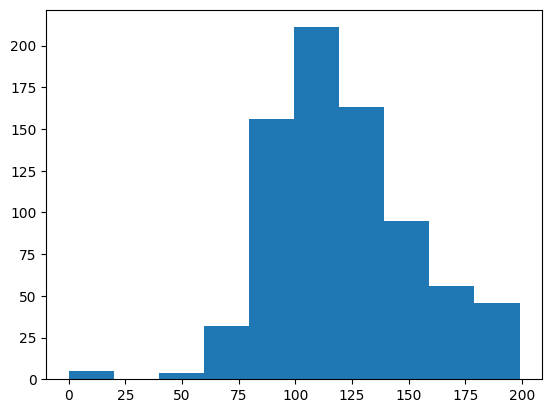

In [47]:
plt.hist(diabetes['Glucose'], bins = 10)

In [48]:
# min 값이 0인 피처에 대해
# - 0의 건수
# - 전체 데이터 건수 대비 비율

zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
total_count = diabetes['Glucose'].count()

for feature in zero_features:
    zero_count = diabetes[diabetes[feature] == 0][feature].count()
    print(feature, zero_count, 100 * zero_count / total_count)

Glucose 5 0.6510416666666666
BloodPressure 35 4.557291666666667
SkinThickness 227 29.557291666666668
Insulin 374 48.697916666666664
BMI 11 1.4322916666666667


In [49]:
# 0 값을 평균 값으로 대체
# 스케일링

from sklearn.preprocessing import StandardScaler

mean_zero_features = diabetes[zero_features].mean()
diabetes[zero_features] = diabetes[zero_features].replace(0, mean_zero_features)

x = diabetes.iloc[:, :-1]
y = diabetes.iloc[:, -1]

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size = 0.2, stratify = y)

lr = LogisticRegression()
lr.fit(x_train, y_train)
y_hat = lr.predict(x_test)
y_prob = lr.predict_proba(x_test)[:, 1]

print(confusion_matrix(y_test, y_hat))
print(accuracy_score(y_test, y_hat))
print(precision_score(y_test, y_hat))
print(recall_score(y_test, y_hat))
print(f1_score(y_test, y_hat))
print(roc_auc_score(y_test, y_prob))

[[86 14]
 [21 33]]
0.7727272727272727
0.7021276595744681
0.6111111111111112
0.6534653465346535
0.8192592592592592


In [50]:
for th in [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.5]:
    y_hat = Binarizer(threshold = th).fit_transform(y_prob.reshape(-1, 1))
    print(confusion_matrix(y_test, y_hat))
    print(accuracy_score(y_test, y_hat))
    print(precision_score(y_test, y_hat))
    print(recall_score(y_test, y_hat))
    print(f1_score(y_test, y_hat))
    print(roc_auc_score(y_test, y_prob))

[[63 37]
 [10 44]]
0.6948051948051948
0.5432098765432098
0.8148148148148148
0.6518518518518519
0.8192592592592592
[[64 36]
 [10 44]]
0.7012987012987013
0.55
0.8148148148148148
0.6567164179104479
0.8192592592592592
[[69 31]
 [12 42]]
0.7207792207792207
0.5753424657534246
0.7777777777777778
0.6614173228346456
0.8192592592592592
[[73 27]
 [15 39]]
0.7272727272727273
0.5909090909090909
0.7222222222222222
0.65
0.8192592592592592
[[75 25]
 [17 37]]
0.7272727272727273
0.5967741935483871
0.6851851851851852
0.6379310344827587
0.8192592592592592
[[81 19]
 [18 36]]
0.7597402597402597
0.6545454545454545
0.6666666666666666
0.6605504587155963
0.8192592592592592
[[85 15]
 [20 34]]
0.7727272727272727
0.6938775510204082
0.6296296296296297
0.6601941747572815
0.8192592592592592
[[86 14]
 [21 33]]
0.7727272727272727
0.7021276595744681
0.6111111111111112
0.6534653465346535
0.8192592592592592


![Alt text](image-12.png)

![Alt text](image-13.png)